In [1]:
import sys
import os
sys.path.append('../')

In [2]:
import torch
import faiss
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from utils.data import get_loaders, get_default_transforms
from utils.metrics import mean_average_precision_at_k
from utils.main import read_py
from utils.constants import TRAIN_CSV, TEST_CSV, TRAIN_DIR, TEST_DIR

c:\Users\Andrii\miniconda3\envs\image_retrieval\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
CONFIG_PATH = '../train_configs/simsiam_resnet50.py' 
CHECKPOINT_PATH = '../checkpoints/simsiam_1_1_resnet50_bs64_100epochs_cosinelr_lr3e-3/epoch=18-step=4921.ckpt'

In [4]:
train_config = read_py(CONFIG_PATH)

In [5]:
model = train_config.CONFIG['model'](**train_config.CONFIG['model_params'])
forward = train_config.CONFIG['forward'](model, **train_config.CONFIG['forward_params'])
forward.load_state_dict(torch.load(CHECKPOINT_PATH)['state_dict'])
forward.eval()
forward.to('cuda')

C:\Users\Andrii\AppData\Local\Temp\ipykernel_27984\4137380802.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  forward.load_state_dict(torch.load(CHECKPOINT_PATH)['state_

SimSiamForward(
  (model): SimSiamModel(
    (backbone): FeatureListNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (act2): ReLU(inplace=True)
          (aa): Identity()
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), s

In [6]:
loaders_config = train_config.CONFIG['loaders']
if 'test_transforms' not in loaders_config:
    loaders_config['test_transforms'] = get_default_transforms('test')
loaders_config['train_transforms'] = get_default_transforms('test')
loaders_config['train_on_test_too'] = False
train_loader, val_loader, test_loader = get_loaders(**loaders_config)

In [7]:
for batch in tqdm(val_loader):
    images, labels = batch
    images = images.to('cuda')
    print(images.shape)
    print(labels.shape)
    with torch.no_grad():
        features = forward(images)[0]
    print(features.shape)
    break

  0%|          | 0/3 [00:00<?, ?it/s]

torch.Size([64, 3, 224, 224])
torch.Size([64])


  0%|          | 0/3 [01:02<?, ?it/s]

torch.Size([64, 1024])


In [8]:
index = faiss.IndexFlatIP(1024)

In [9]:
info_df = pd.DataFrame(columns=["embedding", "label"])

In [10]:
for images, labels in tqdm(train_loader):
    images = images.to('cuda')

    with torch.no_grad():
        outputs = forward(images)[0]

    embeddings = outputs.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    index.add(embeddings)

    info_df = pd.concat([info_df, pd.DataFrame({"embedding": embeddings.tolist(), "label": labels.tolist()})]).reset_index(drop=True)

100%|██████████| 54/54 [01:13<00:00,  1.37s/it]


In [11]:
k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(np.stack(info_df.iloc[:5, 0]), k) # sanity check
print(I)
print(D)

[[   0  631 2532  988]
 [   1 1564 1556  873]
 [   2  975 3213 2382]
 [   3 2137 1489 3075]
 [   4 2010 2966  850]]
[[1.         0.9951027  0.9871344  0.98311585]
 [0.99999994 0.9188509  0.89563537 0.8893774 ]
 [0.99999994 0.98722506 0.98629105 0.97968227]
 [1.0000001  0.9671945  0.9619775  0.9617342 ]
 [0.99999994 0.9811045  0.9648503  0.9584316 ]]


In [12]:
info_df.iloc[I[4]]

,embedding,label
4,"[-0.0013432137202471495, 0.016114290803670883,...",71
2010,"[-0.0024118279106914997, 0.01696130260825157, ...",140
2966,"[0.006005678791552782, 0.024437254294753075, -...",140
850,"[-0.0014137333491817117, 0.03182483837008476, ...",113


In [13]:
all_labels = []
all_preds = []
all_class_lengths = []
for images, labels in tqdm(val_loader):
    images = images.to('cuda')

    with torch.no_grad():
        outputs = forward(images)[0]

    embeddings = outputs.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    D, I = index.search(embeddings, 100)
    all_labels.append(labels.numpy())

    for i in range(len(images)):
        class_ids_top100 = info_df.iloc[I[i], 1].values
        place_values = np.array([0.95**i for i in range(100)])
        preds = np.zeros(1200)
        for j in reversed(range(100)):
            preds[class_ids_top100[j]] = place_values[j]
        
        all_preds.append(preds)
        try:
            label_pos = np.where(class_ids_top100 == labels[i].item())[0][0]
            all_class_lengths.append(D[i, label_pos])
        except:
            all_class_lengths.append(0)
        # all_class_lengths.append(preds[labels[i].item()])
    

all_labels = np.concatenate(all_labels)
all_preds = np.stack(all_preds)

mean_average_precision_at_k(all_labels, all_preds, k=5)


100%|██████████| 3/3 [00:01<00:00,  2.35it/s]


0.2061111111111111

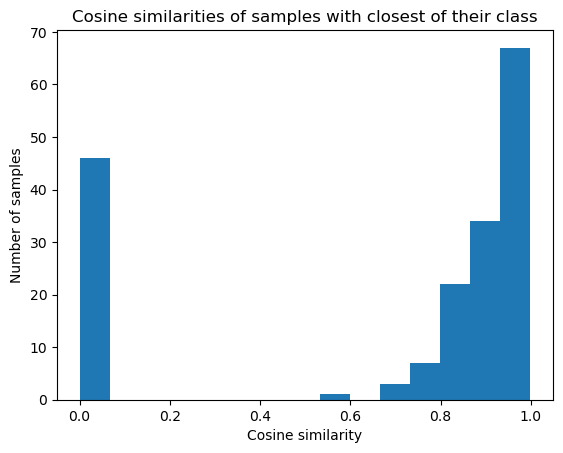

In [51]:
all_class_lengths = np.array(all_class_lengths)
plt.hist(all_class_lengths[all_class_lengths < 100000], bins=15)
plt.title("Cosine similarities of samples with closest of their class")
plt.xlabel("Cosine similarity")
plt.ylabel("Number of samples")
plt.show()

- IP index, projector output: 0.05
- IP index, predictor output: 0.06

In [22]:
# np.percentile(all_class_lengths, 70)

In [23]:
for images, labels in tqdm(val_loader):
    images = images.to('cuda')

    with torch.no_grad():
        outputs = forward(images)[0]

    embeddings = outputs.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    index.add(embeddings)

    info_df = pd.concat([info_df, pd.DataFrame({"embedding": embeddings.tolist(), "label": labels.tolist()})]).reset_index(drop=True)

100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


In [24]:
THRESHOLD = 0.6

In [25]:
test_embeddings = []
for images in tqdm(test_loader):
    images = images.to('cuda')

    with torch.no_grad():
        outputs = forward(images)[0]

    embeddings = outputs.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    test_embeddings.append(embeddings)

100%|██████████| 205/205 [01:24<00:00,  2.44it/s]


In [37]:
test_preds = []
for embeddings in tqdm(test_embeddings):
    D, I = index.search(embeddings, 100)

    for i in range(len(embeddings)):
        class_ids_top100 = info_df.iloc[I[i], 1].values
        # preds = np.ones(1200) * np.inf
        preds = np.zeros(1200)
        for j in reversed(range(100)):
            preds[class_ids_top100[j]] = D[i, j]
        
        top_classes = np.argsort(preds)[::-1][:5]
        top_classes_dists = preds[top_classes]

        # set -1 on the first place after THRESHOLD
        cutoff_location = np.sum(preds > THRESHOLD)
        if cutoff_location < 5:
            for j in range(1, 5 - cutoff_location):
                top_classes[5 - j] = top_classes[5 - j - 1]
            top_classes[cutoff_location] = -1

        test_preds.append(top_classes)

  0%|          | 0/205 [00:00<?, ?it/s]

100%|██████████| 205/205 [00:03<00:00, 65.59it/s]


In [38]:
test_df = pd.read_csv(TEST_CSV)

In [39]:
test_df['class'] = [' '.join([str(el) for el in classes]) for classes in test_preds]

In [40]:
test_df[['file_id', 'class']].to_csv('../submissions/simsiam_resnet_ip_noleak_thresh0.6.csv', index=False)

In [44]:
test_preds = []
for embeddings in tqdm(test_embeddings):
    D, I = index.search(embeddings, 100)

    for i in range(len(embeddings)):
        class_ids_top100 = info_df.iloc[I[i], 1].values
        # preds = np.ones(1200) * np.inf
        preds = np.zeros(1200)
        for j in reversed(range(100)):
            preds[class_ids_top100[j]] = D[i, j]
        
        top_classes = np.argsort(preds)[::-1][:5]
        top_classes_dists = preds[top_classes]

        test_preds.append(top_classes)

  0%|          | 0/205 [00:00<?, ?it/s]

100%|██████████| 205/205 [00:02<00:00, 71.23it/s]


In [45]:
test_df['512x512'] = test_df['file_id'].apply(lambda file_id: (Image.open(os.path.join(TEST_DIR, f'{file_id}.jpg')).size) == (512, 512))

In [46]:
test_df['class'] = [[str(el) for el in classes] for classes in test_preds]

In [47]:
test_df.loc[test_df['512x512'], 'class'] = test_df.loc[test_df['512x512'], 'class'].apply(lambda classes: '-1 ' + ' '.join(classes[:-1]))
test_df.loc[~test_df['512x512'], 'class'] = test_df.loc[~test_df['512x512'], 'class'].apply(lambda classes: ' '.join(classes))

In [48]:
test_df[['file_id', 'class']].to_csv('../submissions/simsiam_resnet_ip_leak.csv', index=False)